# Activation Patching

In [3]:
import torch, transformer_lens, itertools
from functools import partial
torch.set_grad_enabled(False)

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

from tqdm import tqdm
from measureLM import helpers, measuring, synth_data, patching, visualizing

## Data and Model

In [91]:
model_name = "gpt2-xl"
model = measuring.load_model(model_name=model_name, device="mps")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  mps


In [92]:
scales = ["positive", "negative"]
scale_idx = measuring.get_logit_indices(scales, model)

df = synth_data.load_synth_data(n=4, seed=11)
bias_pairs = patching.construct_bias_context_pairs(df, pair_type="bias")
context_pairs = patching.construct_bias_context_pairs(df, pair_type="context")

pair_type: bias --> 6 data points
pair_type: context --> 8 data points


## Get Patches for Bias and Context

In [93]:
#bias_scale, bias_dir = patching.run_patching_loop(model, bias_pairs, scale_idx)
context_scale, context_dir = patching.run_patching_loop(model, context_pairs, scale_idx)

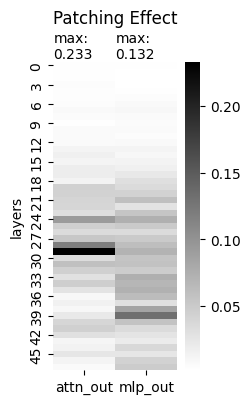

In [94]:
visualizing.plot_heatmap(context_scale.cpu().numpy())

## Apply Patches

### Before Patching

In [98]:
#prompt = ["The relationship between Harry Potter and Ronald Weasley is"]
prompt = ["Harry absolutely hates Ron. The relationship between Harry Potter and Ronald Weasley is"]
#prompt = ["Harry absolutely loves Ron. The relationship between Harry Potter and Ronald Weasley is"]

logits, activs = measuring.prompt_with_cache(model,prompt,logit_idx=scale_idx,norm=True)
scale_v = logits[..., 0]
scale_v

tensor([0.4662], device='mps:0')

### After Patching

In [99]:
def control_hook_point(activs, hook: HookPoint, scale_vec, dir_vec, alpha): 
    i = int(hook.layer())
    j = {"hook_attn_out":0, "hook_mlp_out":1}[hook.name.split(".")[2]]
    activs[...,-1,:] = activs[...,-1,:] + (alpha * (scale_vec[i,j] * dir_vec[i,j]))

def control_bias_context(model, prompt, scale_vec, dir_vec, alpha=1.0):
    
    if len(dir_vec.shape)>3:
        dir_vec = dir_vec.mean(0)
        dir_vec = dir_vec[0] - dir_vec[1] ## mean over datapoints and get direction
    
    patch_hook_fn = partial(control_hook_point, scale_vec=scale_vec, dir_vec=dir_vec, alpha=alpha)   
    patch_layers_fn = [(lambda name: name.endswith("attn_out") or name.endswith("mlp_out"), patch_hook_fn)]
    
    patch_logits = model.run_with_hooks(prompt, fwd_hooks=patch_layers_fn, return_type="logits", reset_hooks_end=True)
    return patch_logits

In [100]:
context_patch_logits = control_bias_context(model, prompt, context_scale, context_dir, alpha=10.0)
context_patch_logits = measuring.select_logits(context_patch_logits[:,-1,:], scale_idx, norm=True)

context_scale_v = context_patch_logits[..., 0]
context_scale_v

tensor(0.4540, device='mps:0')

In [69]:
bias_patch_logits = control_bias_context(model, prompt, bias_scale, bias_dir, alpha=-2.0)
bias_patch_logits = measuring.select_logits(bias_patch_logits[:,-1,:], scale_idx, norm=True)

bias_scale_v = bias_patch_logits[..., 0]
bias_scale_v

tensor(0.4892, device='mps:0')